In [111]:
# Draft pour le rendu final 

# Datasets à utiliser: users.csv, beers.csv, reviews.txt.gz 
# (on se focus que sur 1 site pour le moment, à savoir beeradvocate/ratebeer?)

#beers.csv
# print les 5 premières lignes
# d'où viennent les bières par continent 
# 14 catégories faites par le site lui même https://www.beeradvocate.com/beer/styles/ + 1 "weird cocktail"
# combien de bières ont été ratées par nos valid users (après partie filtre rating maybe)

#users.csv
# print les 5 premières lignes
# on regarde le pourcentage des US. Hypothèse: les américains ont accès aux mêmes bières
# discussion autour des valid users -> combien de ratings

# reviews.txt.gz
# d'abord print des exemples de reviews entières (avec le texte etc.)
# Mentionner que le data-set est immense
# Expliquer comment on a loadé les données et les colonnes qu'on a drop pour 
# qu'on puisse gérer le dataset
# Ajoute les ratings, leur temporalité et tous les ratings détaillés (en gros 
# ce que ce que dataset nous apporte)
# Plot de Pale
# Plot de Maxime

# Pour répondre a notre question:
# Métrique de la validité
# Plot de Pale 
# Approche avec les Graphes: on explique la construction pour un user, la construction
# du graphe final, les différentes manières de construire les weights,  
# "Algorithme de Louvain" -> lots of mathematical details (une mesure de clustering)



In [112]:
#ICI CA PARLE souvent de df_ratings_99 ... il est def ou ? et on l'utilise ou èas ???

In [113]:
import pandas as pd
import seaborn as sns
import datetime
import sys
import gzip
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pylab
import scipy.stats as stats

In [114]:
plt.style.use('default')
pd.options.mode.chained_assignment = None  # default='warn'

### 

In the datatsets we have, we are interested in 3 different datasets : users.csv, beers.csv, reviews.txt.gz. These are presents for 2 websites : RateBeer and BeerAdvocate. We first focus on BeerAdvocate website.

## Dataset beers.csv

First of all, we look the "beers.csv" in more details

In [115]:
#load the data beers.csv
df_beers = pd.read_csv('./data/beers.csv')

In [116]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [117]:
print(df_beers.shape)

(280823, 15)


We have a total of  280823 beers with 15 variables

For the following, we will consider these variables:
- beer_id and beer_name : the ID and name of the beer
- brewery id and name : the ID and name of the brewery where the considered beers comes from
- style: this variable indicates the category of the beer. There are many different categories and we will explain later how we manage to reduce this number.
- nbr_reviews and nbr_ratings : the number of reviews and ratings respectively for a given beer
- avg : it corresponds to the average ratings for a given beer
- abv : the alcohol by volume percentage
- The other columns are a variety of scores computed for the beer, which we will not use

In [118]:
list_considered_variable=['beer_id','beer_name','brewery_id','brewery_name','style',
                          'nbr_reviews','nbr_ratings','avg', 'abv']
df_beers=df_beers[list_considered_variable]

In [119]:
df_beers['nbr_ratings'].describe()

count    280823.000000
mean         29.887267
std         231.010063
min           0.000000
25%           1.000000
50%           2.000000
75%           8.000000
max       16509.000000
Name: nbr_ratings, dtype: float64

We observe that 75% of the beers have at most 8 ratings. After this observation, we decided that it might be a good idea to group the beers into categories since we don't want to remove the 75% percent of the beers we have. To do so, we decided to create a variable 'category'. We decided to used the 14 categories for the style made in https://www.beeradvocate.com/beer/styles/.  We also added the category 'Weird cocktail' as this category does not exist anymore.

We create here a dict to map one sub-category to its parent, and vice-versa.

In [120]:
beer_catalog = {
    'Bocks' : ['Bock', 'Doppelbock', 'Eisbock', 'Maibock', 'Weizenbock', 'Maibock / Helles Bock'],

    'Dark Ales' : ['Dubbel', 'Roggenbier', 'Scottish Ale', 'Winter Warmer'],

    'Hybrid Beers' : ['Bière de Champagne / Bière Brut', 'Braggot', 'California Common / Steam Beer', 'Cream Ale'],

    'Pale Ales' : ['American Amber / Red Ale', 'American Blonde Ale', 'American Pale Ale', 'Belgian Blonde Ale',
    'Belgian Pale Ale', 'Bière de Garde', 'English Bitter', 'English Pale Ale', 'English Pale Mild Ale', 'Extra Special / Strong Bitter (ESB)',
    'Grisette', 'Irish Red Ale', 'Kölsch', 'Saison', 'Saison / Farmhouse Ale', 'Belgian Strong Pale Ale', 'American Pale Ale (APA)'],

    'Porters' : ['American Porter', 'Baltic Porter', 'English Porter', 'Imperial Porter', 'Robust Porter ', 'Smoked Porter'],

    'Stouts' : ['American Imperial Stout', 'American Stout', 'English Stout', 'Foreign / Export Stout', 'Irish Dry Stout', 'Oatmeal Stout',
    'Russian Imperial Stout', 'Milk / Sweet Stout', 'American Double / Imperial Stout'],

    'Wheat Beers' : ['American Dark Wheat Beer', 'American Pale Wheat Beer', 'Dunkelweizen', 'Grodziskie', 'Hefeweizen', 'Kristallweizen', 'Witbier', 
    'American Pale Wheat Ale', 'American Dark Wheat Ale', 'Berliner Weissbier', 'Kristalweizen'],

    'Brown Ales' : ['Altbier', 'American Brown Ale', 'Belgian Dark Ale', 'English Brown Ale', 'English Dark Mild Ale', 'Belgian Strong Dark Ale'],

    'Dark Lagers' : ['American Amber / Red Lager', 'Czech Amber Lager', 'Czech Dark Lager', 'European Dark Lager', 'Märzen',
    'Munich Dunkel', 'Rauchbier', 'Schwarzbier', 'Vienna Lager', 'Munich Dunkel Lager', 'Euro Dark Lager'],

    'India Pale Ales' : ['American IPA', 'American Double / Imperial IPA', 'Belgian IPA', 'Black IPA', 'Brut IPA', 'English IPA', 'English India Pale Ale (IPA)', 
    'Imperial IPA', 'Milkshake IPA', 'New England IPA', 'American Black Ale'],

    'Pale Lagers' : ['American Adjunct Lager', 'American Lager', 'Bohemian / Czech Pilsner', 'Czech Pale Lager', 'European / Dortmunder Export Lager',
    'European Pale Lager', 'European Strong Lager', 'Festbier / Wiesnbier', 'German Pilsner', 'Helles', 'Imperial Pilsner', 'India Pale Lager (IPL)',
    'Kellerbier / Zwickelbier', 'Light Lager', 'Malt Liquor', 'Czech Pilsener', 'Euro Pale Lager', 'American Pale Lager', 'German Pilsener', 'Dortmunder / Export Lager', 
    'Euro Strong Lager', 'Munich Helles Lager', 'American Double / Imperial Pilsner', 'American Malt Liquor', 'Märzen / Oktoberfest'],

    'Specialty Beer' : ['Chile Beer', 'Fruit and Field Beer', 'Gruit / Ancient Herbed Ale', 'Happoshu', 'Herb and Spice Beer', 'Japanese Rice Lager',
    'Kvass', 'Low-Alcohol Beer', 'Pumpkin Beer', 'Rye Beer', 'Sahti', 'Smoked Beer', 'Herbed / Spiced Beer', 'Pumpkin Ale', 'Scottish Gruit / Ancient Herbed Ale', 'Low Alcohol Beer'],

    'Strong Ales' : ['American Barleywine', 'American Strong Ale', 'Belgian Dark Strong Ale', 'Belgian Pale Strong Ale', 'English Barleywine', 'English Strong Ale',
    'Imperial Red Ale', 'Old Ale', 'Quadrupel (Quad)', 'Scotch Ale / Wee Heavy', 'Tripel', 'Wheatwine', 'Fruit / Vegetable Beer'],
    
    'Wild/Sour Beers' : ['Berliner Weisse', 'Brett Beer', 'Faro', 'Flanders Oud Bruin', 'Flanders Red Ale', 'Fruit Lambic',
    'Fruited Kettle Sour', 'Gose', 'Gueuze', 'Lambic', 'Wild Ale', 'Lambic - Unblended', 'Lambic - Fruit', 'American Wild Ale'],

    'Weird Cocktail' : ['Black & Tan']
}

In [121]:
beer_catalog_reverse = {}
for key, values in beer_catalog.items():
    for value in values:
            beer_catalog_reverse.setdefault(value, []).append(key)

Here, we create a function to map the sub-category to its parent, and then apply it to the dataset.

In [122]:
def category_check(beer_style, beer_catalog):
    '''
    Return the new columns of 15 categories made in the website https://www.beeradvocate.com/beer/styles/
    '''
    for category_name, beer_styles in beer_catalog.items():
        if beer_style in beer_styles:
            return category_name

In [123]:
df_beers['category'] = df_beers['style'].apply(lambda beer_style: category_check(beer_style, beer_catalog))

In [124]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_reviews,nbr_ratings,avg,abv,category
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.7,Pale Lagers
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,3.8,Pale Lagers
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.8,Pale Lagers
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.0,Pale Lagers
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.5,Pale Lagers


We want now to investigate how the categories we created are represented

In [125]:
#REDONDANCE SIZE AND Y

#Create new data frame for the plot 
cat=df_beers.groupby('category').count()["beer_id"]
cat=cat.reset_index()
cat = cat.sort_values(by=['beer_id'], ascending=True)
cat=cat.reset_index()
#normalize to have a percentage per category 
cat["beer_id"] = cat["beer_id"]/cat["beer_id"].sum()*100
cat['ind']=cat.index
df = px.data.gapminder()

fig = px.scatter(cat, x="ind", y="beer_id",
     size="beer_id", color="category",
                 hover_name="category", size_max=80,labels={"ind": "Category",
                     "beer_id": "Total number of beers per category"})
fig.show()

In this plot above, we can see the  number of beers in each category in percentage. Also, bigger the circle is more there are beers in the category.  We can see that 'Pale Ales' is quite highly represented (almost 25% of the beers are in this category).  The second most represented category is 'Indian Pale Ales'  (represented at almost 18%). For the further analysis, we will have to be  careful about how each category is represented.

We now focus on the average of the ratings for each category

In [126]:
df_beers.groupby('category')["avg"].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bocks,5037.0,3.706750,0.438740,1.12,3.50,3.76,3.99,5.0
Brown Ales,12362.0,3.709714,0.420009,0.00,3.50,3.75,3.98,5.0
Dark Ales,4879.0,3.693782,0.418825,0.00,3.50,3.75,3.95,5.0
Dark Lagers,5563.0,3.559590,0.488692,0.00,3.32,3.65,3.88,5.0
Hybrid Beers,2739.0,3.629474,0.444672,1.00,3.43,3.68,3.90,5.0
India Pale Ales,45381.0,3.849004,0.389755,0.00,3.65,3.88,4.09,5.0
Pale Ales,58963.0,3.675394,0.425130,0.00,3.48,3.73,3.95,5.0
Pale Lagers,19642.0,3.324800,0.627132,0.00,2.96,3.46,3.77,5.0
Porters,11235.0,3.810827,0.405798,0.00,3.62,3.85,4.05,5.0


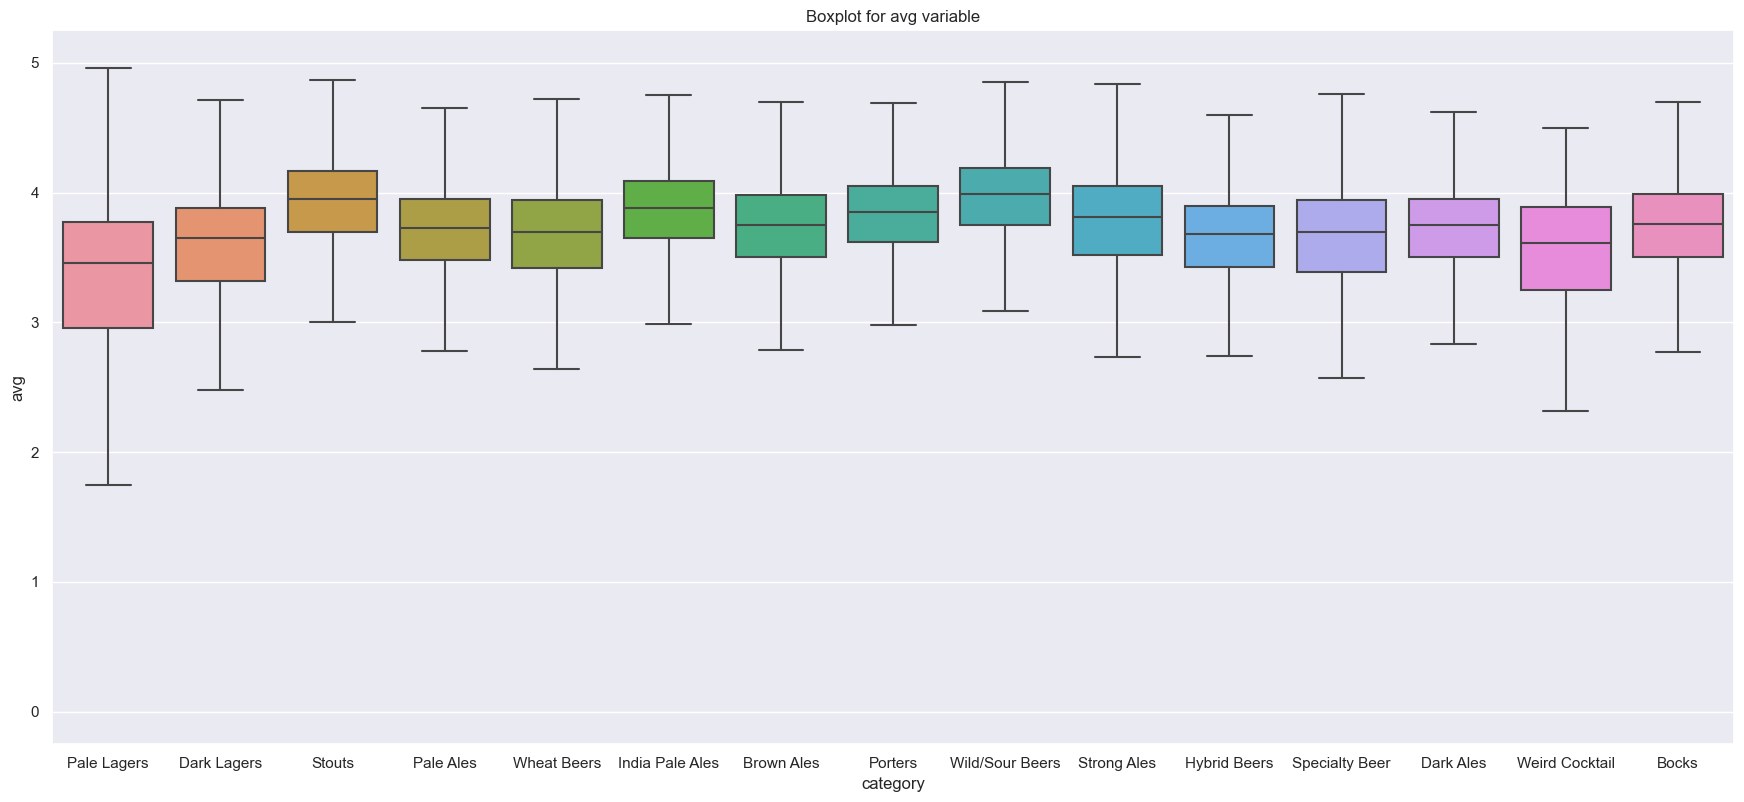

In [127]:
sns.set(rc={'figure.figsize':(21.7,9.27)})
sns.boxplot(data=df_beers, x="category", y="avg",fliersize=0).set(
   title='Boxplot for avg variable')
pass

We can observe that there is not a lot of differences between the average of the ratings for each category. One can observe that the variance for the category 'Pale Lagers' is little higher. It can be explained by the large numbers of beers that falls in this category compared to others categories

## Dataset users.cvs

User informations are usefull to select valid user for our experiment. For exemple, we want only users from the USA (because they all have access to the same market) or users that have a reasonable number of ratings.

In [128]:
#load the data
df_users = pd.read_csv('./data/users.csv')
print(df_users.describe())
df_users.head(5)

         nbr_ratings    nbr_reviews        joined
count  153704.000000  153704.000000  1.510520e+05
mean       54.605163      16.847876  1.357238e+09
std       252.388790     139.846706  9.195131e+07
min         1.000000       0.000000  8.407944e+08
25%         1.000000       0.000000  1.303121e+09
50%         3.000000       0.000000  1.391944e+09
75%        16.000000       2.000000  1.417691e+09
max     12046.000000    8970.000000  1.501495e+09


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


The features that characterize users are self-explanatory:
- nbr_ratings : the number of ratings a user has given
- nbr_reviews : the number of reviews a user has given
- user_id : internal database representation BeerAdvocate chose for their users
- user_name : the username chosen by the user on the website
- joined : the date when the users joined the website, expressed as a Unix timestamp
- location : where the users comes from

The difference between a review and a rating:

A review is a rating which the user decided to elaborate using a small text.
Users have the choice to comment their ratings: if they decide to do so, they are doing a review.
If they do not comment their rating, then BeerAdvocate refers to it as a rating.
Notice that every review is a rating, but not vice versa.

### Analysis

In [129]:
total_nb_users = df_users.user_name.nunique()
print("Total number of user : ", total_nb_users)
print("Number of user with 0 rating : ", df_users[df_users.nbr_ratings == 0].user_name.nunique())

Total number of user :  153703
Number of user with 0 rating :  0


In [130]:
#How many people from the US?
df_us_users = df_users[df_users.location.str.contains('United States', na = False)]
number_us_users = df_us_users.user_name.nunique()
print("Number of user from the USA : ",number_us_users)

print(f"{number_us_users/total_nb_users*100:.02f}% of the people comes from the USA.")


Number of user from the USA :  113222
73.66% of the people comes from the USA.


In [131]:
#Around all 50 states of America. -> distribution by state?
print("Number of states : ", df_us_users.location.nunique())

Number of states :  50


We choose to only keep users from the USA as they all have acces to the same beer market. Moreover, they represent a vast majority of the total user, we thus still have a large dataset to work with.

Let us now focus on the number of ratings done by US users.

With the help of a QQ-Plot, we can get a first grasp of the data distribution

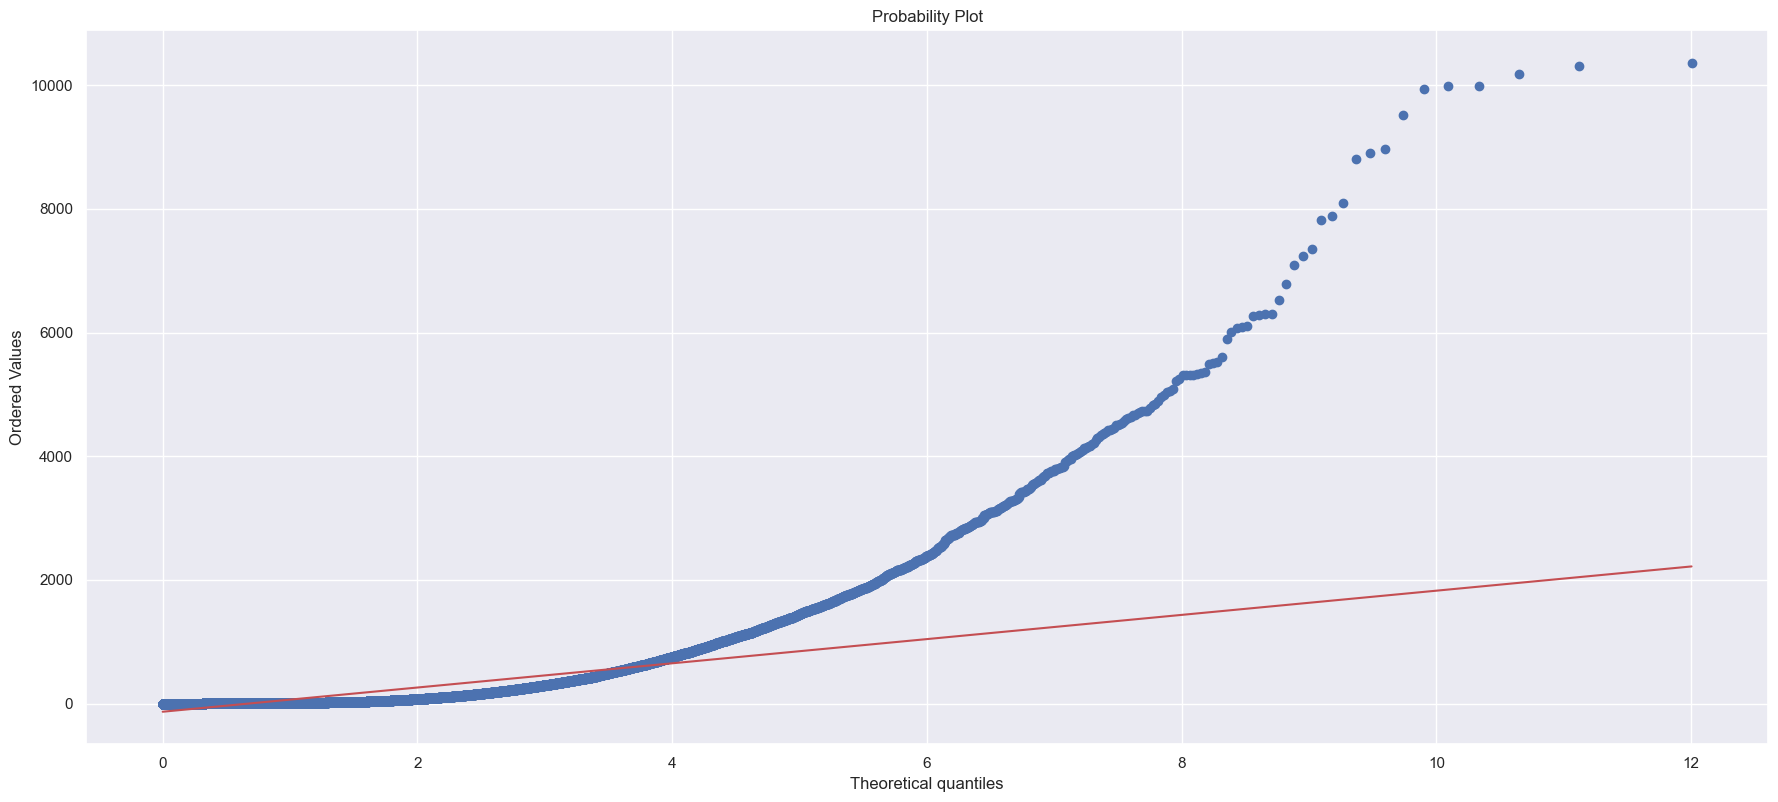

In [132]:
stats.probplot(df_us_users.nbr_ratings, dist = "expon", plot=pylab)
pass

The distribution looks extremely heavy tailed. 

Lets look at some simple statistics:

In [133]:
nb_ratings_us_users = df_us_users.nbr_ratings.sum()
print(nb_ratings_us_users)
df_us_users['nbr_ratings'].describe()

7303870


count    113223.000000
mean         64.508713
std         274.707015
min           1.000000
25%           1.000000
50%           4.000000
75%          22.000000
max       10360.000000
Name: nbr_ratings, dtype: float64

50% of US users rated less than 4 beers on the website.

In [134]:
percentile = np.arange(0.8, 1, 0.02)
df_us_users['nbr_ratings'].describe(percentiles= percentile)

count    113223.000000
mean         64.508713
std         274.707015
min           1.000000
50%           4.000000
80%          35.000000
82%          43.000000
84%          54.000000
86%          69.000000
88%          90.000000
90%         119.000000
92%         166.000000
94%         239.000000
96%         371.000000
98%         703.000000
max       10360.000000
Name: nbr_ratings, dtype: float64

With the above observation, we can clearly see that We have some heavy-hitters in our data-set, which we will need to filter out later on. 

For example, let us look at the 10 users with the most ratings

In [135]:
top_ten_us_users = df_us_users.sort_values(by = 'nbr_ratings', ascending = False).head(10)
top_ten_us_users

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
1352,10360,66,acurtis.508168,acurtis,1.285582e+09,"United States, New Jersey"
1583,10302,34,texasfan549.572853,Texasfan549,1.298718e+09,"United States, Texas"
969,10180,2091,kylehay2004.571365,kylehay2004,1.298459e+09,"United States, Illinois"
994,9991,1122,grg1313.288024,GRG1313,1.232017e+09,"United States, California"
9,9987,16,jaydoc.265507,jaydoc,1.226488e+09,"United States, Kansas"
967,9944,8768,uclabrewn84.439438,UCLABrewN84,1.268910e+09,"United States, California"
672,9520,51,spycow.205702,spycow,1.206270e+09,"United States, Illinois"
1286,8970,8970,stonedtrippin.601042,StonedTrippin,1.306577e+09,"United States, Colorado"
516,8898,0,kjkinsey.472192,kjkinsey,1.277201e+09,"United States, Texas"
1353,8813,2,djrn2.389332,djrn2,1.257332e+09,"United States, New Jersey"


In [136]:
nb_ratings_top_ten = top_ten_us_users.nbr_ratings.sum()
print("Number of ratings done by the top 10 : ", nb_ratings_top_ten)
print(f"The top 10 has done {nb_ratings_top_ten/nb_ratings_us_users*100:.2f}% of the ratings")

Number of ratings done by the top 10 :  96965
The top 10 has done 1.33% of the ratings


10 users are responsible for roughly 1.3% of the total number of reviews!

We will have to be very careful in the way we select our users and need to determine a method to filter out outliers.

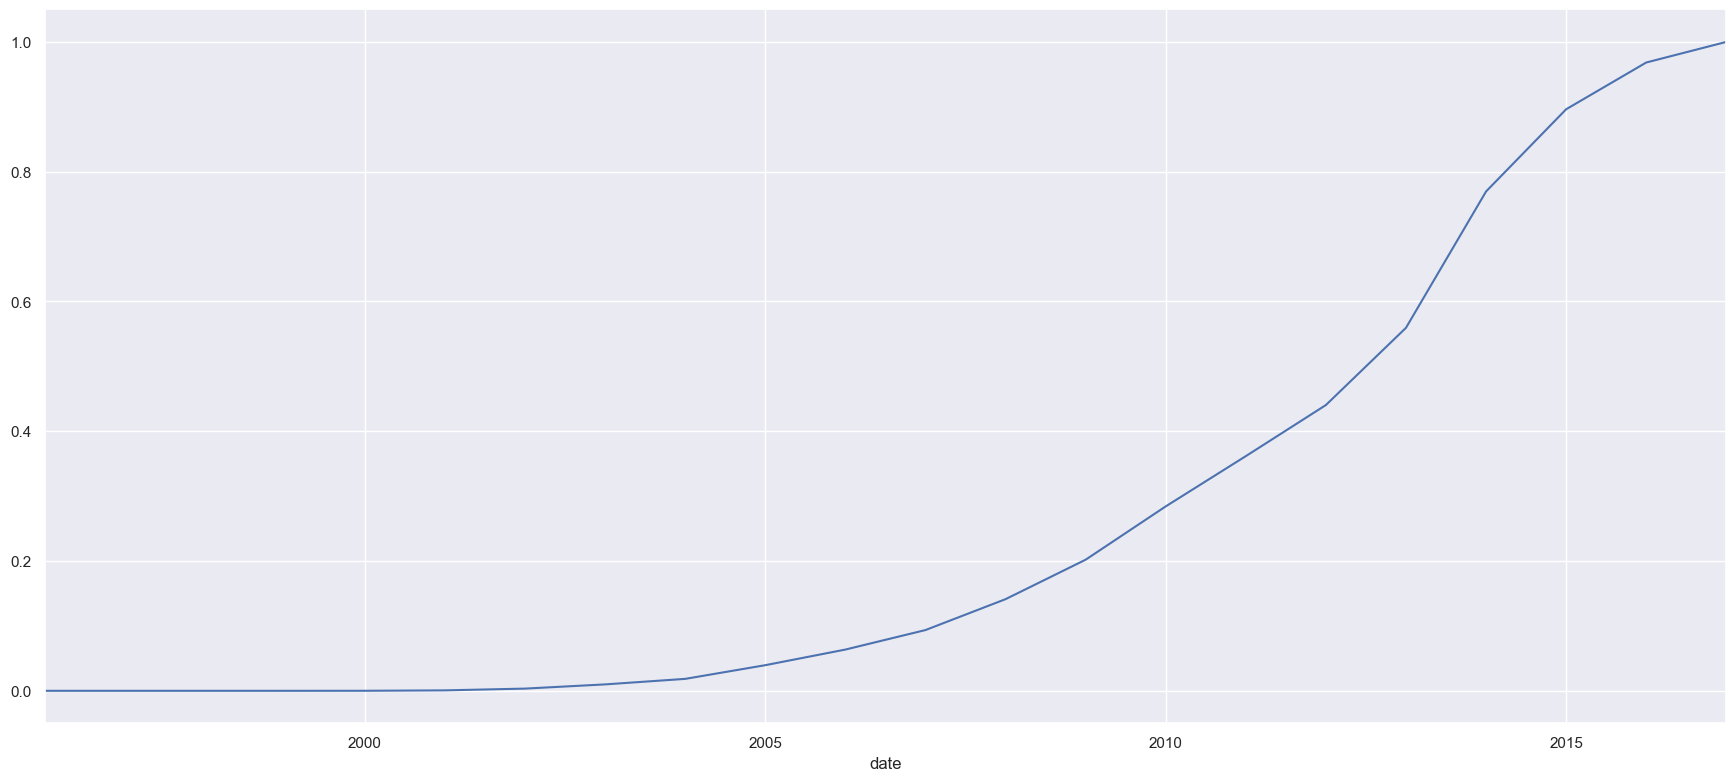

In [137]:
# Increase of number of US users through time.
df_us_users.loc[:,'date'] = pd.to_datetime(df_us_users['joined'].apply(lambda dt : datetime.datetime.fromtimestamp(dt).strftime('%Y-%m-%d')))
df_us_users.head(5)
df_users_year = df_us_users[['date','user_id']].groupby(pd.Grouper(freq = 'Y', key = 'date')).count()
df_users_year['cumulated'] = df_users_year['user_id'].cumsum().div(number_us_users)
df_users_year.cumulated.plot()
pass

In [138]:
# 7 people joined before the ratings that we have? Who are they lol

joined_before = pd.to_datetime('2001-01-01')
us_users_joined = df_us_users[df_us_users.date < joined_before]
us_users_joined

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,date
42,1888,1887,beeradvocate.1,BeerAdvocate,840794400.0,"United States, Massachusetts",1996-08-23
163,4602,3561,jason.3,Jason,840794400.0,"United States, Massachusetts",1996-08-23
165,1699,1085,todd.2,Todd,840794400.0,"United States, California",1996-08-23
6498,18,16,javier.9,javier,977396400.0,"United States, Massachusetts",2000-12-21
18250,125,106,qxster1.12,QXSTER1,977742000.0,"United States, Pennsylvania",2000-12-25
23074,6,2,mevans05.6,mevans05,977310000.0,"United States, Massachusetts",2000-12-20
76584,1,0,mmakunas.10,mmakunas,977396400.0,"United States, California",2000-12-21


Wow, we found the founders of Beer Advocate: the two brothers, Jason and Todd Alstrom!! xD xD xD xD xD XD XD XD XD

Say HI to them!!

<img src="./data/creators.jpeg" class="img-responsive" alt=""> </div>

This also shows us that there are some organizations on the website : filtering must be done!!

### Filtering of users

Based on the previous analysis, we will now select a set of valid user.

In [139]:
#keep user from the USA only
df_us_users = df_users[df_users.location.str.contains('United States', na=False)]

#choose a minimum number of ratings per user, since we want to analyse an evolution
cutoff_low = 10 #subjective, good so ?
print("Cuttof low : ", cutoff_low)

#choose a maximum number of ratings per user, we want to filter our super-users or organisations
cutoff_high = df_us_users.nbr_ratings.quantile(0.99)
print("Cuttof low : ", cutoff_high)

#create a valid user dataframe and a set with the valid user_names
df_valid_us_users = df_us_users[(df_us_users.nbr_ratings < cutoff_high) &
                                (df_us_users.nbr_ratings >= cutoff_low)]
valid_us_users_names = set(df_valid_us_users.user_name)
print("Number of users left : ", len(valid_us_users_names))
print("total of ratings left : ", df_valid_us_users.nbr_ratings.sum())

Cuttof low :  10
Cuttof low :  1135.0
Number of users left :  39548
total of ratings left :  4675463


With this filtering, outliers are remooved and we still have enough data to work with. The filtering we did is subjective, and can still be adapted.

Note that we will still have to filter more based on the file ratings.txt

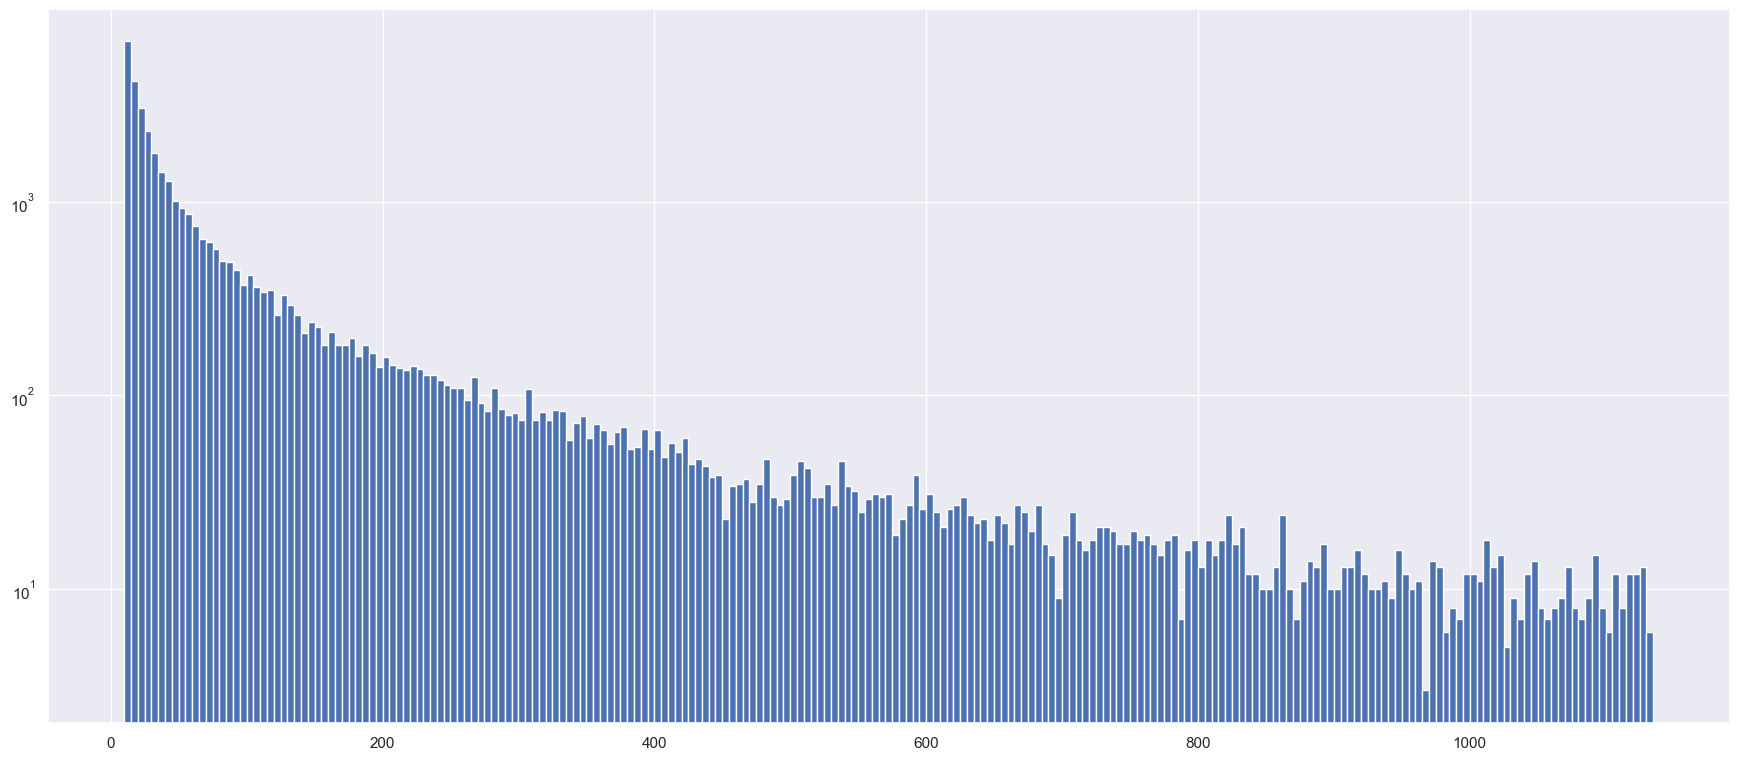

In [140]:
#the above plot shows the number of user per rating number, it looks like an exponential distribution
binwidth = 5
plt.hist(df_valid_us_users.nbr_ratings, bins=range(min(df_valid_us_users.nbr_ratings),
         max(df_valid_us_users.nbr_ratings) + binwidth, binwidth), log=True)
pass

## Dataset reviews.txt.gz

This will be our main dataset. It contains the informations we want to build our datastory on.

However, the format used to store the data is not universal and is not supported by pandas reading functions. We have adapted an helper function to parse the txt.gz file and return a generator. The generator is then used to recurively build the pandas dataframe.

In [141]:
def parse(filename):
    """
    Parse a txt.gz file and return a generator for it
    Copyright © 2017 Gael Lederrey <gael.lederrey@epfl.ch>
    :param filename: name of the file
    :return: Generator to go through the file
    """
    file = gzip.open(filename, 'rb')
    entry = {}
    # Go through all the lines
    for line in file:
        # Transform the string-bytes into a string
        line = line.decode("utf-8").strip()

        # We check for a colon in each line
        colon_pos = line.find(":")
        if colon_pos == -1:
            # if no, we yield the entry
            yield entry
            entry = {}
            continue
        # otherwise, we add the key-value pair to the entry
        key = line[:colon_pos]
        value = line[colon_pos + 2:]
        entry[key] = value

To build the dataframe, we have implemented a framework that goes trought the generator and only keeps the desired column. Simply loading the whole dataset was costly because some features where too heavy for ours computers (mainly the text review, total dataset size of 0.9Gb). We have also casted some of the columns to the right datatype to save some space (e.g. casting the column "beer_id" as an int is lighter than keeping it as a pandas object). 

In [142]:
gen = parse('./data/ratings.txt.gz')

In [143]:
create = False

if create:
    undesired_features = set(['text','review', 'brewery_name', 'brewery_id', 'user_id', 'beer_name'])
    full_ratings_ls = []
    int_cols = ['beer_id']
    float_cols = ['abv','appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

    review = next(gen)
    cols = [key for key, _ in review.items() if key not in undesired_features]

    for idx, review in enumerate(gen):
        user_name = review['user_name']
        valid_rows = [value for key, value in review.items() if key not in undesired_features]
        if user_name in valid_us_users_names:
            full_ratings_ls.append(valid_rows)

    df_ratings = pd.DataFrame(full_ratings_ls, columns = cols)

    df_ratings[int_cols] = df_ratings[int_cols].astype('int')
    df_ratings[float_cols] = df_ratings[float_cols].astype('float') 
    df_ratings["date"] = pd.to_datetime(df_ratings.date.apply(
        lambda date : datetime.datetime.fromtimestamp(int(date)).strftime('%Y-%m-%d')
    ))
    df_ratings.to_pickle('./data/ratings_us.pkl')

else:
    df_ratings = pd.read_pickle('./data/ratings_us.pkl')

The dataframe is then saved in pickle format. 

In [144]:
print(df_ratings.shape)
df_ratings.head(5)


(4675432, 11)


,beer_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating
0,19827,English Pale Ale,4.8,2014-02-10,OKCNittany,NaN,NaN,NaN,NaN,NaN,3.75
1,19827,English Pale Ale,4.8,2013-02-13,brewdude1982,4.25,4.5,3.25,3.75,3.75,3.91
2,19827,English Pale Ale,4.8,2012-12-02,BYOFB,NaN,NaN,NaN,NaN,NaN,3.50
3,19827,English Pale Ale,4.8,2012-11-24,CadensDad,NaN,NaN,NaN,NaN,NaN,4.00
4,19827,English Pale Ale,4.8,2012-11-17,ferrari29,3.00,3.5,2.50,2.50,2.50,2.77


We can now perfom some analysis to explore the data. 

### Ratings

We want to see how much rating they is in each beer category

To do so, we first have to add a column where each style is mapped to its parents beer style.

In [145]:

beers_id_cat = df_beers[['beer_id', 'category']]
df_ratings_cat = pd.merge(df_ratings, beers_id_cat, on = 'beer_id')

if False:
    df_ratings_cat.to_pickle("./data/df_ratings_cat.pkl")
if False:
    df_ratings_cat = pd.read_pickle("./data/df_ratings_cat.pkl")

In [146]:
print(df_ratings_cat[["style", "category"]].sample(3))


#We have 15 unique categegories, as expected
print("number of category : ", df_ratings_cat.category.nunique())

                 style         category
3872823   American IPA  India Pale Ales
956856    American IPA  India Pale Ales
3999380  Winter Warmer        Dark Ales
number of category :  15


<AxesSubplot:xlabel='category'>

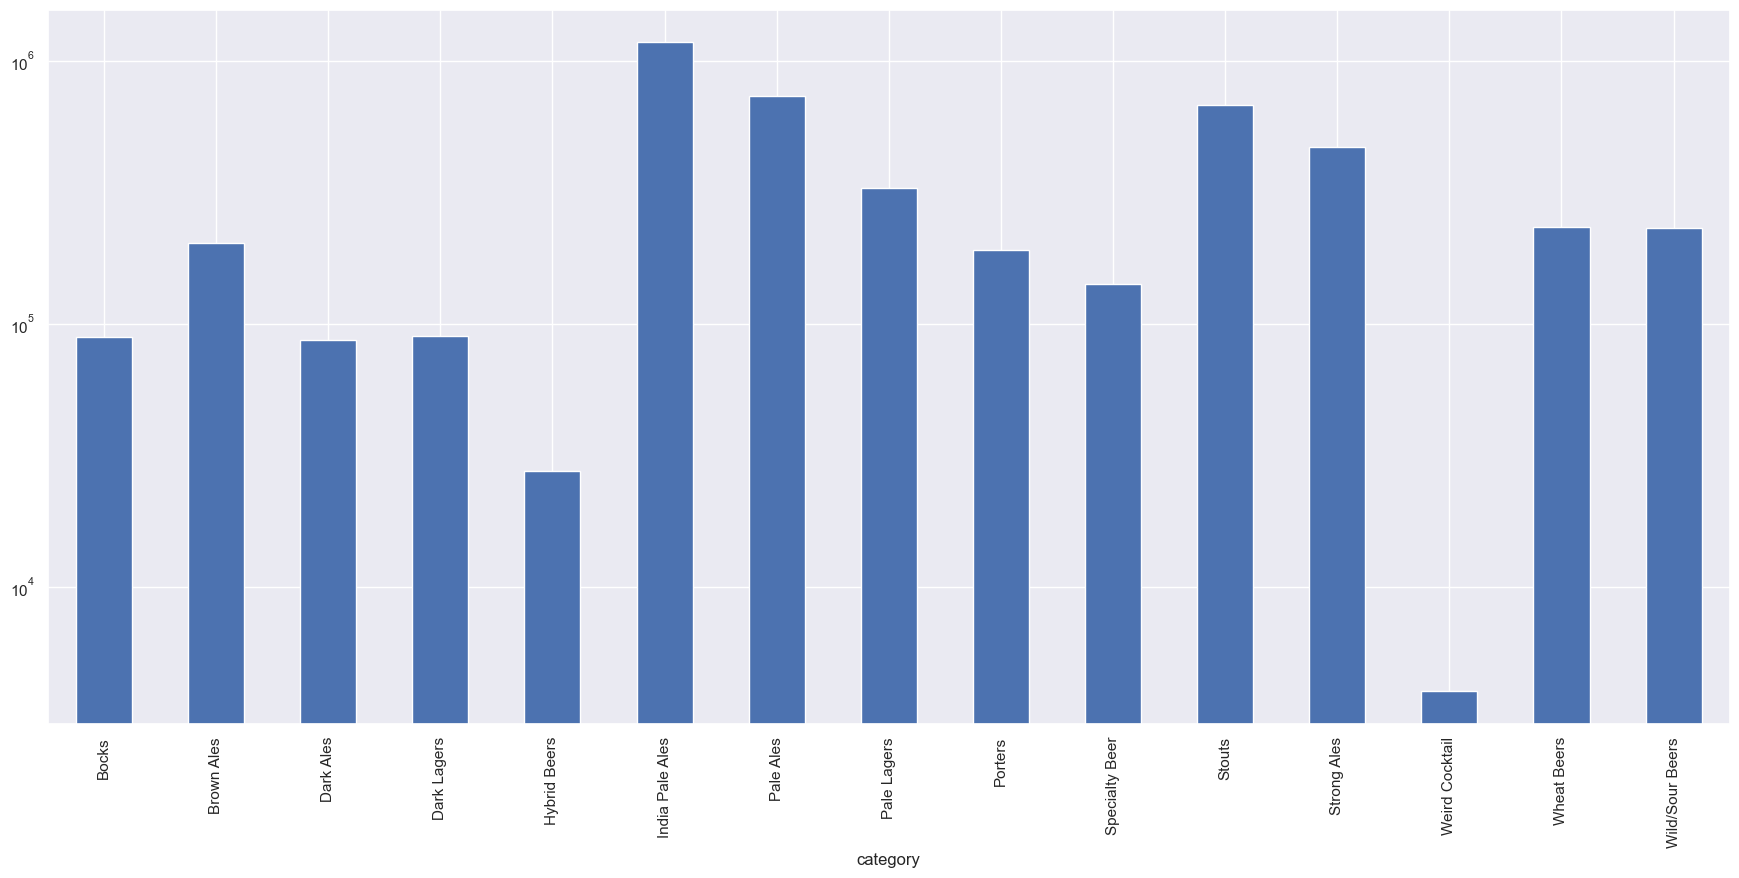

In [147]:
#Distribution of all ratings on the website!
df_category_cnt = df_ratings_cat.groupby('category').rating.count()
df_category_cnt.plot(kind = 'bar', logy = True)

### Ratings over time

Fist, we will look at the distribution of all the ratings of the valid user over time. 

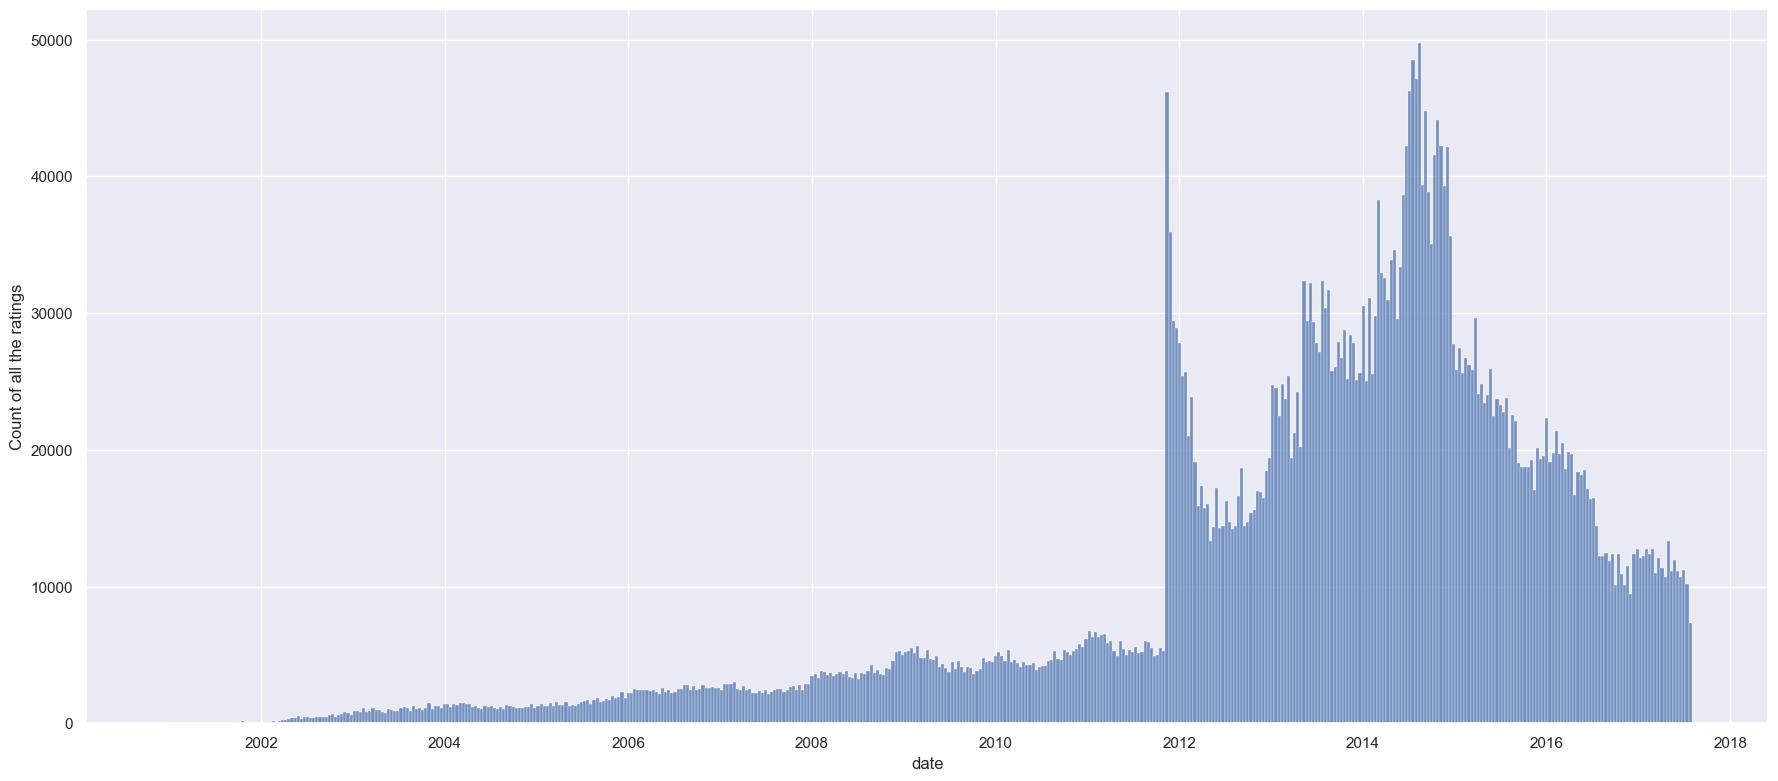

In [148]:
fig, ax1 = plt.subplots()
sns.histplot(df_ratings.date)
ax1.set_xlabel('date')
ax1.set_ylabel('Count of all the ratings')
plt.show()

Then we are also intersted in finding the first rating of each user (i.e. thier joining date)

In [149]:
first_rating_per_user=df_ratings.groupby(['user_name']).apply(lambda group : group.date.min())

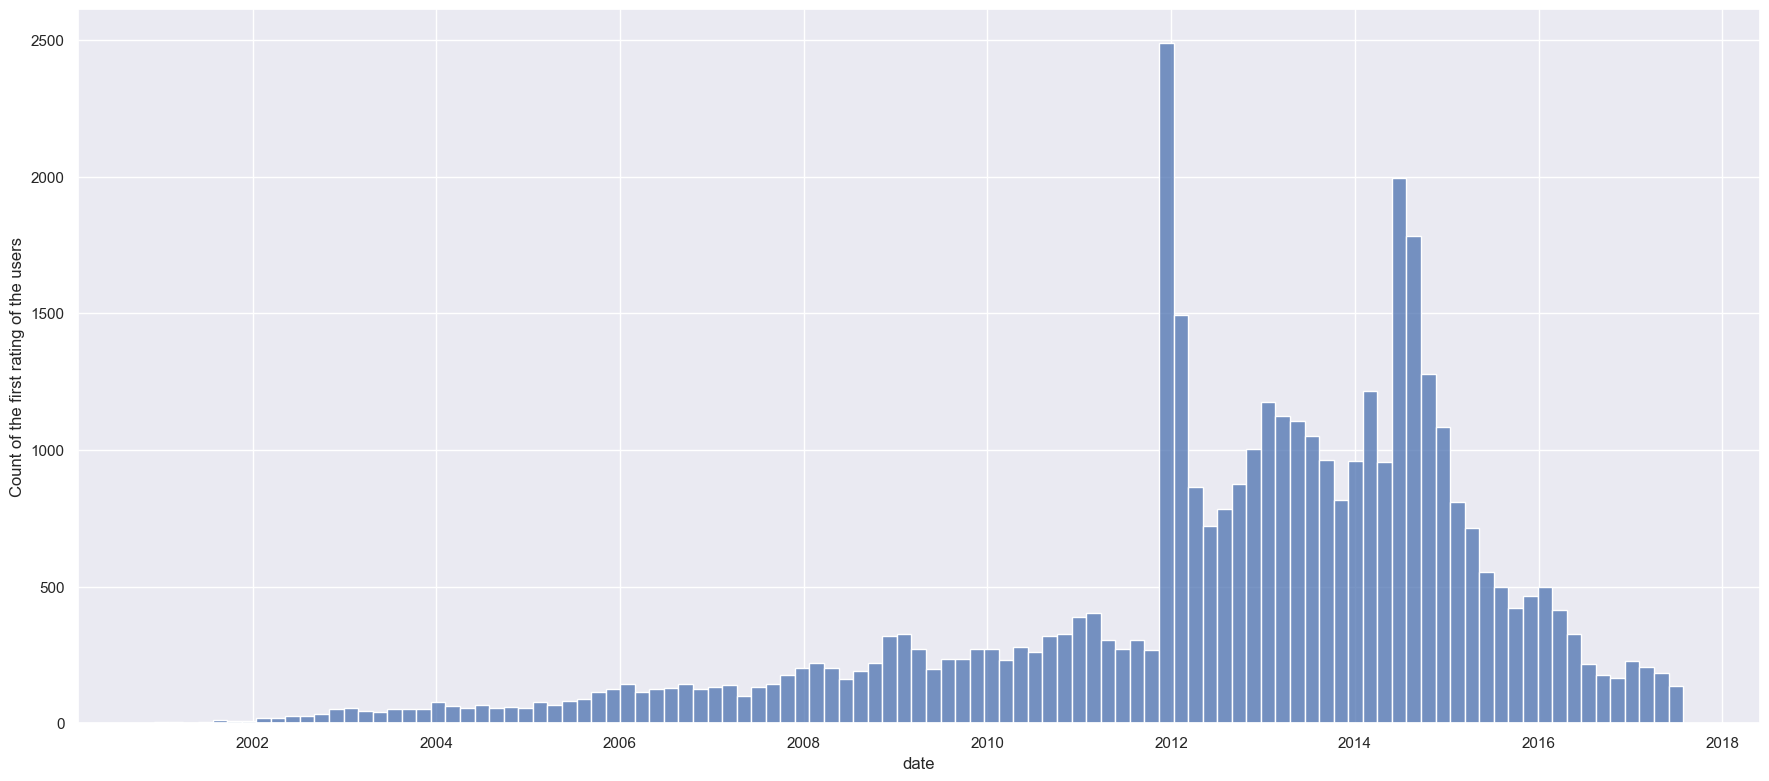

In [150]:
fig, ax1 = plt.subplots()
sns.histplot(first_rating_per_user)
ax1.set_xlabel('date')
ax1.set_ylabel('Count of the first rating of the users')
plt.show()

In both case, there is a huge spike in 2012. We did some researched, and apparently, beerAdvocate had a data breach in this period. We dont think that this will be a probleme for our analysis thought. 

#WHY ??

### ratings of each category of beer over time

We want to see how each category of beer evolves over time. We will plot the number of rating per category over time.

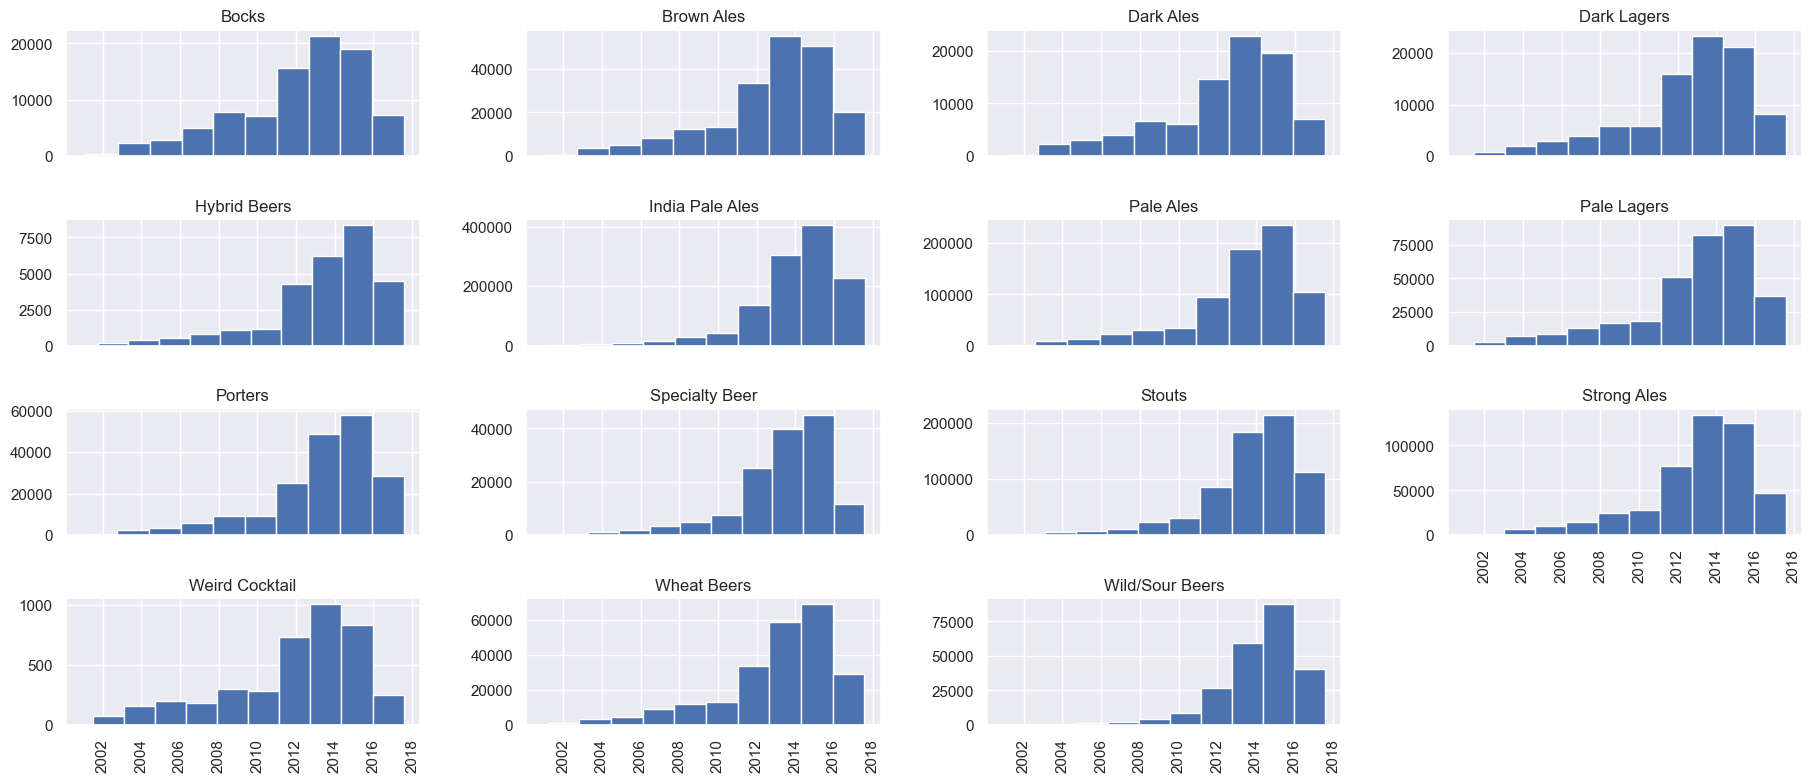

In [151]:
#time serie of each beer /!\ the y axis is NOT the same 
df_ratings_cat["date"].hist(by=df_ratings_cat["category"], sharex=True, sharey=False)
pass

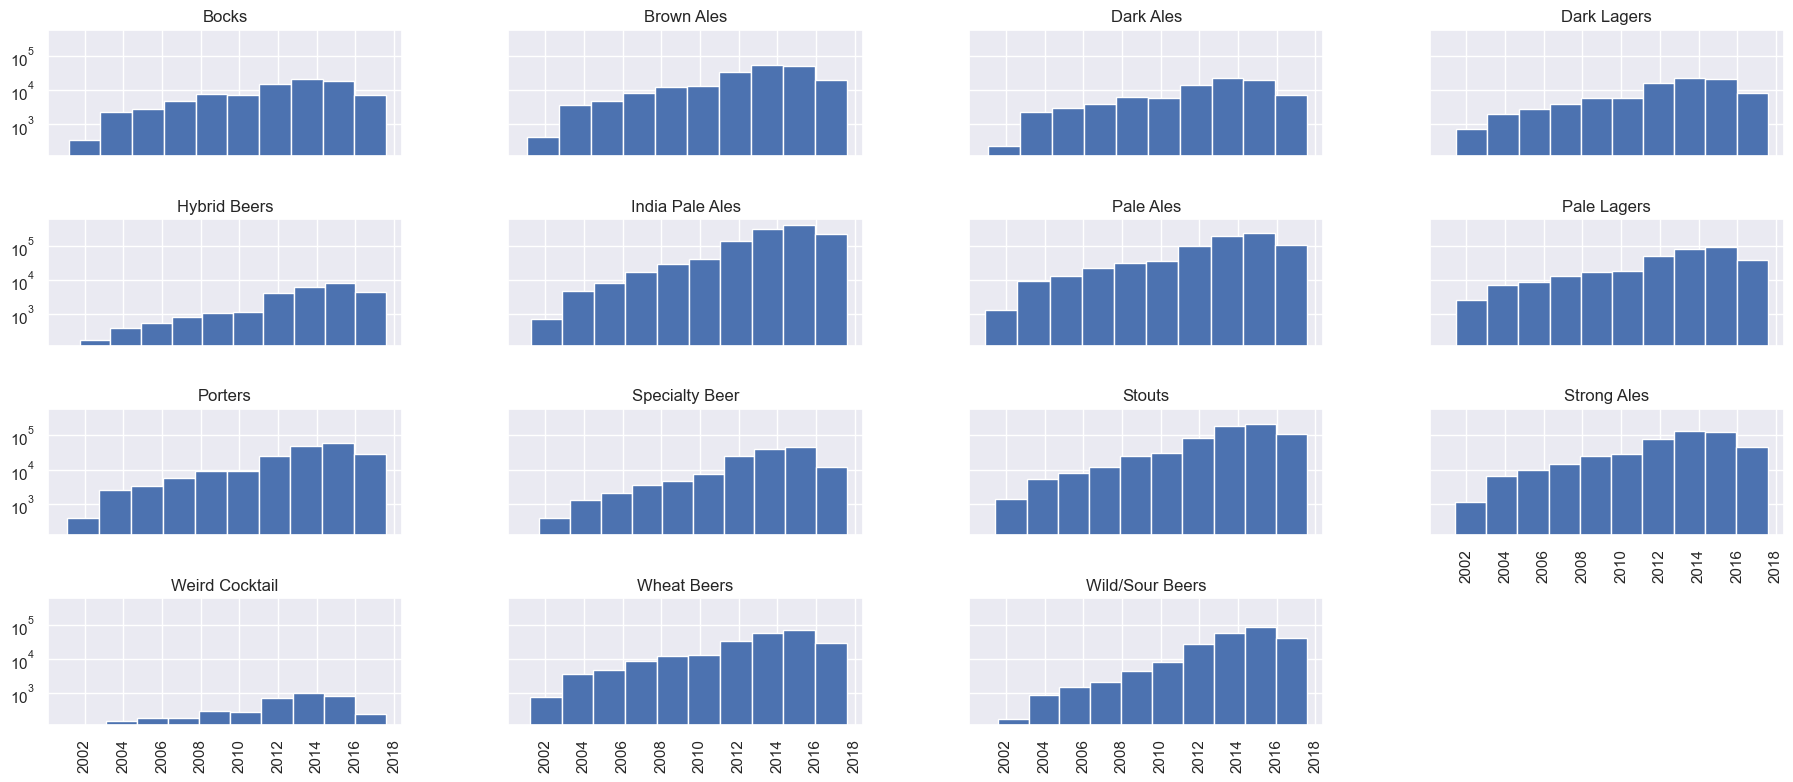

In [152]:
#the same graph, with a log scale and shared y-axis
df_ratings_cat["date"].hist(by=df_ratings_cat["category"], sharex=True, sharey=True, log = True)
pass

These plot are hardly readable, and even less comparable. It would be better to plot everything on a same graph. This required that we normalize each category by the total number of ratings in a chosen timeframe. Here, we choose to look at the distribution considering bins of one year.

In [153]:
#here we count how much ratings each category recieved for each year
cat_year = df_ratings_cat.groupby([pd.Grouper(freq="Y", key="date"), "category"])["beer_id"].count().reset_index()
print(cat_year.sample(3))
print(cat_year.shape)

          date      category  beer_id
185 2013-12-31  Hybrid Beers     4055
199 2014-12-31   Dark Lagers    18714
61  2005-12-31         Bocks     1860
(256, 3)


In [154]:
#Total number of ratings per year
review_year = cat_year.groupby("date").sum().reset_index()
print(review_year.sample(3))
print(review_year.shape)

         date  beer_id
2  2002-12-31    11833
4  2004-12-31    36779
11 2011-12-31   292483
(18, 2)


In [155]:
#For each row (i.e. beer category over one year), we want to have both the number of ratings of
# the category and the total number of ratings over all the category over the year.
merge_data=cat_year.merge(review_year, left_on="date", right_on="date")
merge_data['ratio']=merge_data["beer_id_x"]/merge_data["beer_id_y"]
print(merge_data.sample(3))
merge_data.shape

         date        category  beer_id_x  beer_id_y     ratio
85 2006-12-31  Specialty Beer       2199      72839  0.030190
61 2005-12-31           Bocks       1860      46464  0.040031
79 2006-12-31     Dark Lagers       2406      72839  0.033032


(256, 5)

In [156]:
#Each style over the whole period is grouped in a list of list
hists = []
for cat in merge_data["category"].unique():
    hists.append(merge_data.ratio[merge_data["category"]==cat].to_list())

ValueError: x and y must have same first dimension, but have shapes (17,) and (18,)

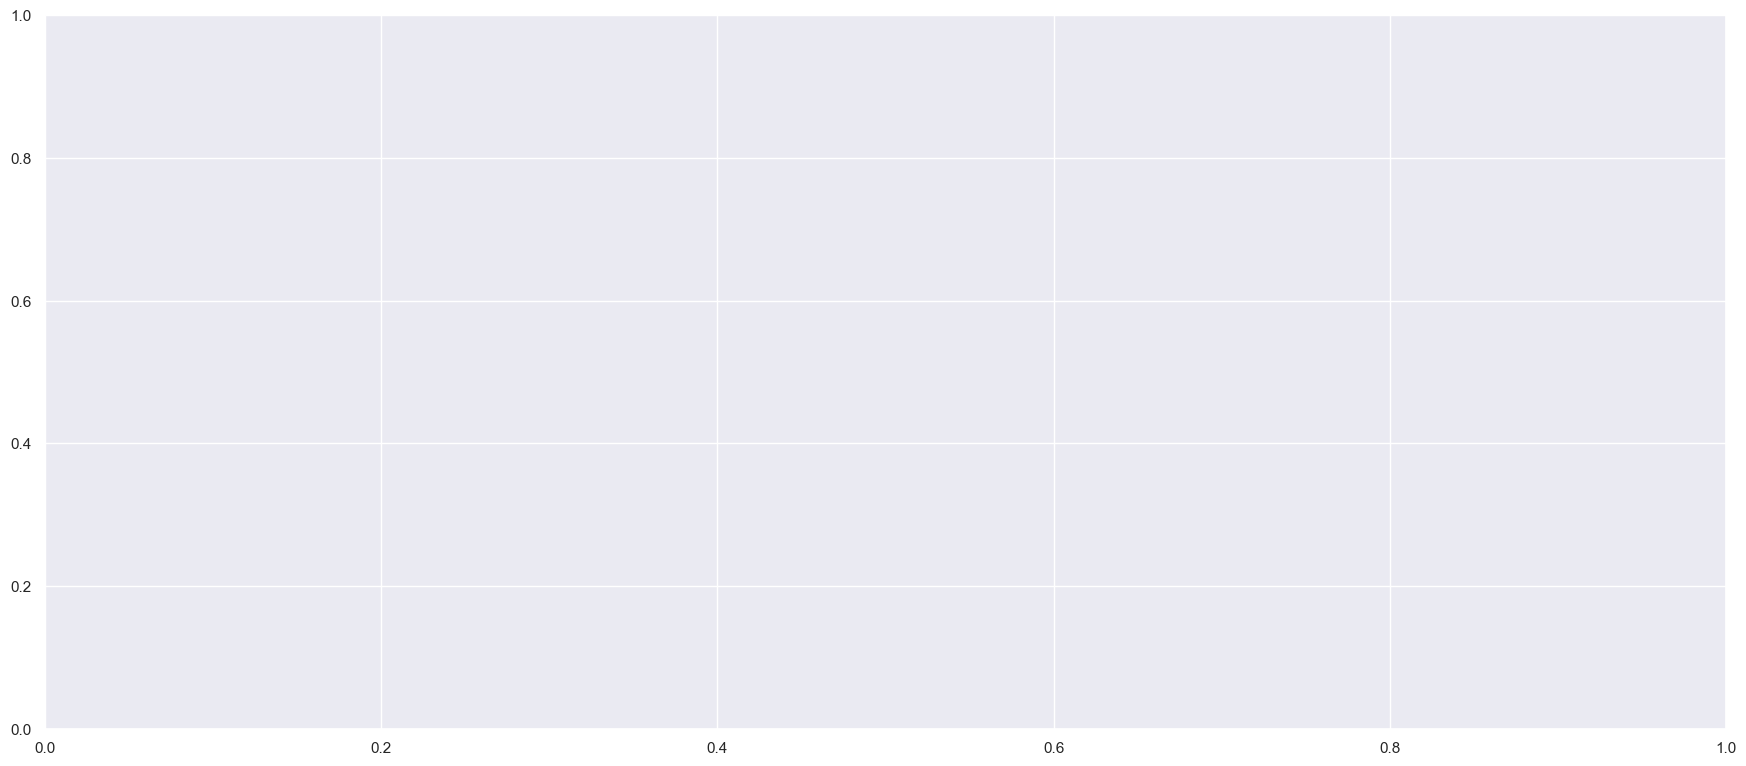

In [158]:
x = range(2001,2018)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/15) for i in range(15)])
for i, hist in enumerate(hists):
    ax.plot(x[0:len(hist)],hist, label=merge_data["category"].unique()[i])

plt.xlabel("Years")
plt.ylabel("Ratio of rating per category per year")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The final graph gives us much informations. It shows for each year, the percentage of ratings that each style of beer got.

In 2017, 35% of the ratings are of IPAs !
we can clearly see the rise of popularity for the IPAs and Stouts, it will be important to take this into account when evaluating the evolution on a single user.


### User's 5 first and last ratings

Since we want to investigate the evolution of the user's taste over time, it would be interesting to see with wich beer the user "started" and "ended".

 We will look at the distribution of each beer category over the five first ratings of all the users. In other words, beers which category will the user rate first.

In [ ]:
df_ratings_cat.head(1)

,beer_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating,category
0,90101,Saison / Farmhouse Ale,6.2,2013-10-19,laxer8811,NaN,NaN,NaN,NaN,NaN,4.25,Pale Ales


# a partir de la j'ai juste copier le code, peut tre quon peut epurer

In [ ]:
def first_ratings_user(ratings, first = 5, last = 5):
    ratings_sorted = ratings.sort_values(by = 'date')
    first_ratings = ratings_sorted[:first]
    last_ratings = ratings_sorted[-last:]
    first_categories = list(set(first_ratings.category))
    last_categories = list(set(last_ratings.category))
    return first_categories, last_categories

In [ ]:

#SLOW
df_first = df_ratings_cat[['user_name', 'date', 'category']]
df_first = df_first.groupby('user_name').apply(lambda user_rating: pd.Series({'first_last_cats' : first_ratings_user(user_rating)})).reset_index()
df_first['first_cats'] = df_first['first_last_cats'].apply(lambda cats: cats[0])
df_first['last_cats'] = df_first['first_last_cats'].apply(lambda cats: cats[1])
df_first = df_first.drop(['first_last_cats'], axis = 1)

In [ ]:
#Try to check if some categories (dis)appear between the first 5 and the last 5 ratings

df_first['nb_cat_first'] = df_first['first_cats'].apply(lambda cat: len(cat))
df_first['nb_cat_last'] = df_first['last_cats'].apply(lambda cat: len(cat))
df_first.head(5)

,user_name,first_cats,last_cats,nb_cat_first,nb_cat_last
0,--Dom--,"[India Pale Ales, Stouts, Strong Ales]","[India Pale Ales, Pale Lagers]",3,2
1,-BobWeaver-,[India Pale Ales],[India Pale Ales],1,1
2,-MK-,"[India Pale Ales, Stouts, Wheat Beers, Dark La...","[India Pale Ales, Bocks]",4,2
3,-NESTO-,"[Pale Ales, Stouts, Wheat Beers, Strong Ales]","[Pale Ales, Stouts, Wild/Sour Beers]",4,3
4,-Rick,"[India Pale Ales, Stouts]","[Stouts, Wild/Sour Beers]",2,2


#### User diverity in the 5 first ratings

Text(0.5, 1.0, 'How many different categories valid users mention in their first 5 ratings')

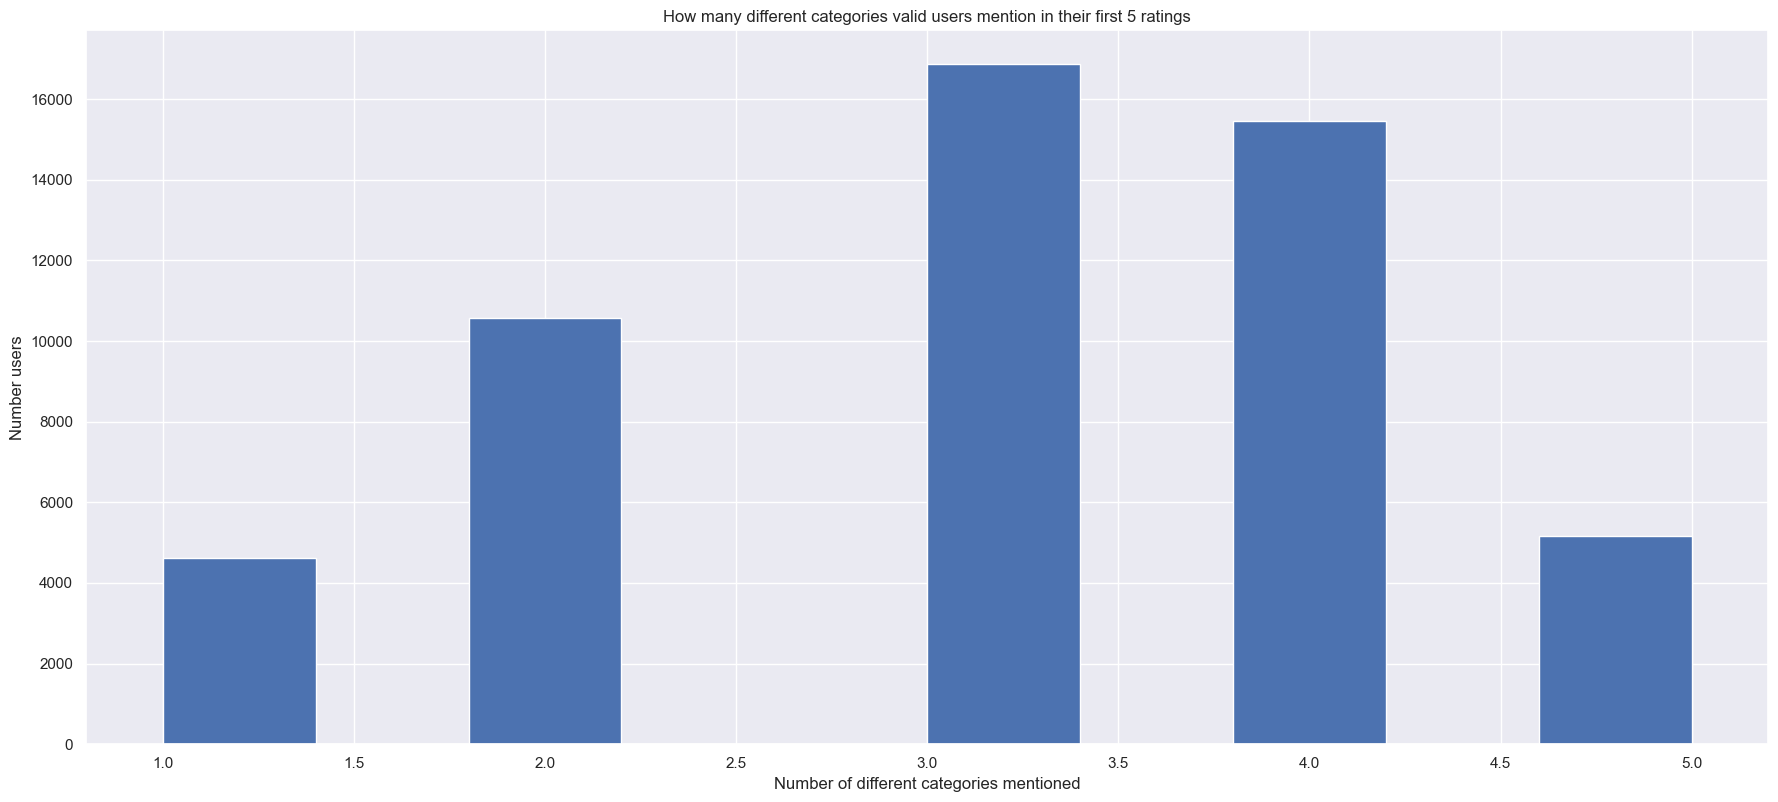

In [ ]:
plt.hist(df_first.nb_cat_first)
plt.xlabel('Number of different categories mentioned')
plt.ylabel('Number users')
plt.title('How many different categories valid users mention in their first 5 ratings')

Text(0.5, 1.0, 'How many different categories valid users mention in their last 5 ratings')

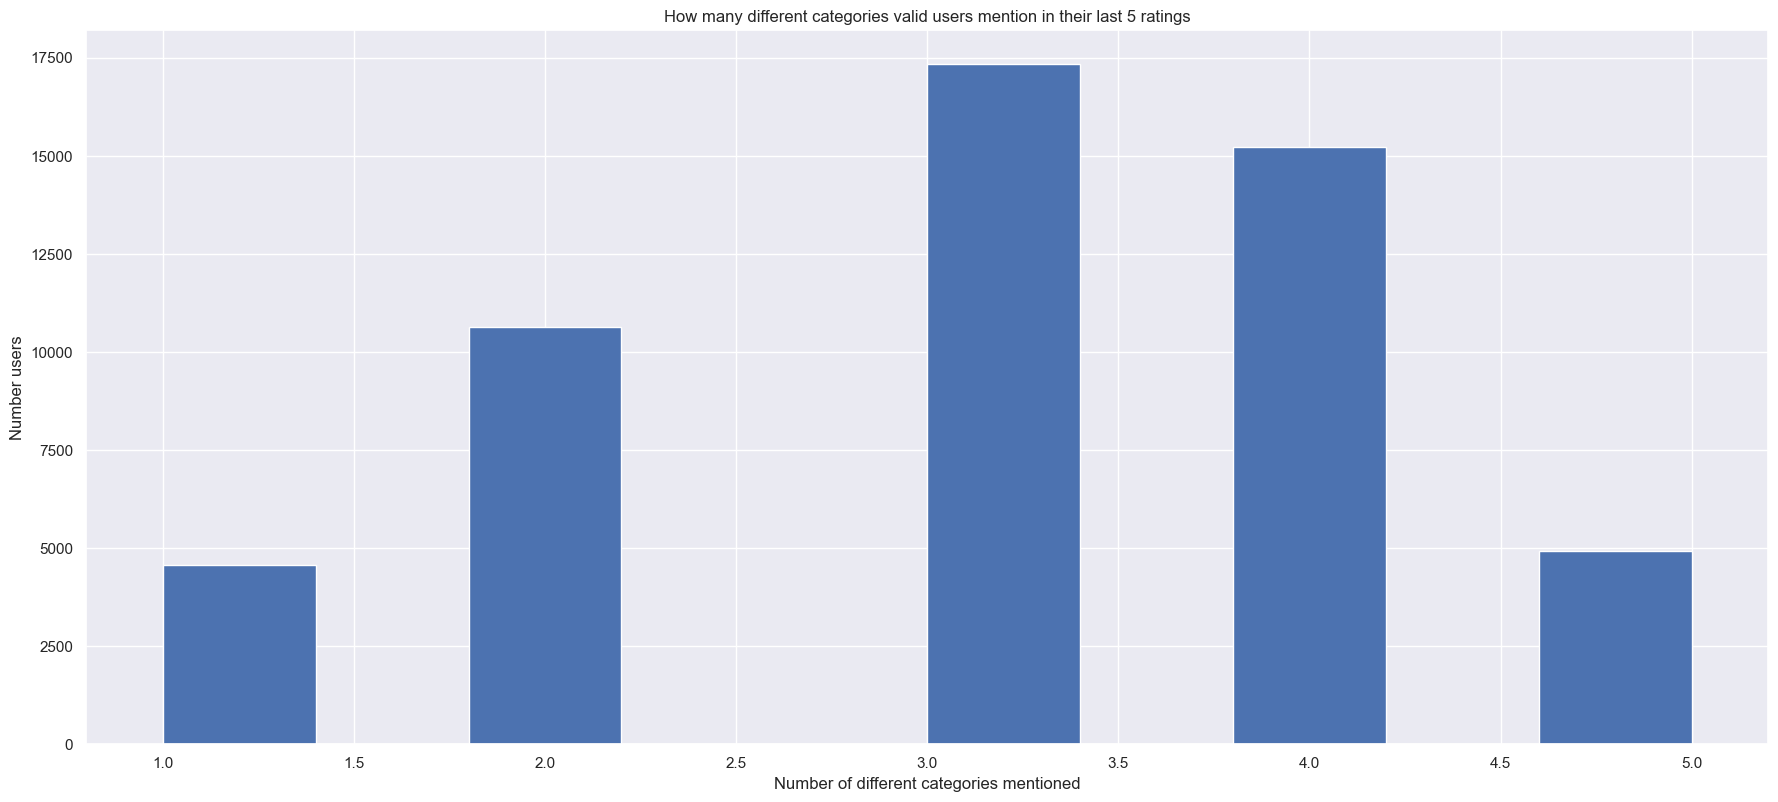

In [ ]:
plt.hist(df_first.nb_cat_last)
plt.xlabel('Number of different categories mentioned')
plt.ylabel('Number users')
plt.title('How many different categories valid users mention in their last 5 ratings')

#### Wich category dominated

In [ ]:
first_categories = df_first['first_cats']
last_categories = df_first['last_cats']

In [ ]:
def category_counter(categories):
    mydict = {}
    for first_categories in categories:
        for cat in first_categories:
            if cat in mydict.keys():
                mydict[cat] += 1
            else:
                mydict[cat] = 1 
    return mydict

In [ ]:
first_categories_dict = category_counter(first_categories)
last_categories_dict = category_counter(last_categories)
first_categories_dict

{'India Pale Ales': 31945,
 'Stouts': 21805,
 'Strong Ales': 17720,
 'Wheat Beers': 10162,
 'Dark Lagers': 4332,
 'Pale Ales': 26331,
 'Wild/Sour Beers': 5402,
 'Brown Ales': 11050,
 'Pale Lagers': 10582,
 'Weird Cocktail': 360,
 'Porters': 8556,
 'Specialty Beer': 6925,
 'Bocks': 3530,
 'Dark Ales': 4679,
 'Hybrid Beers': 678}

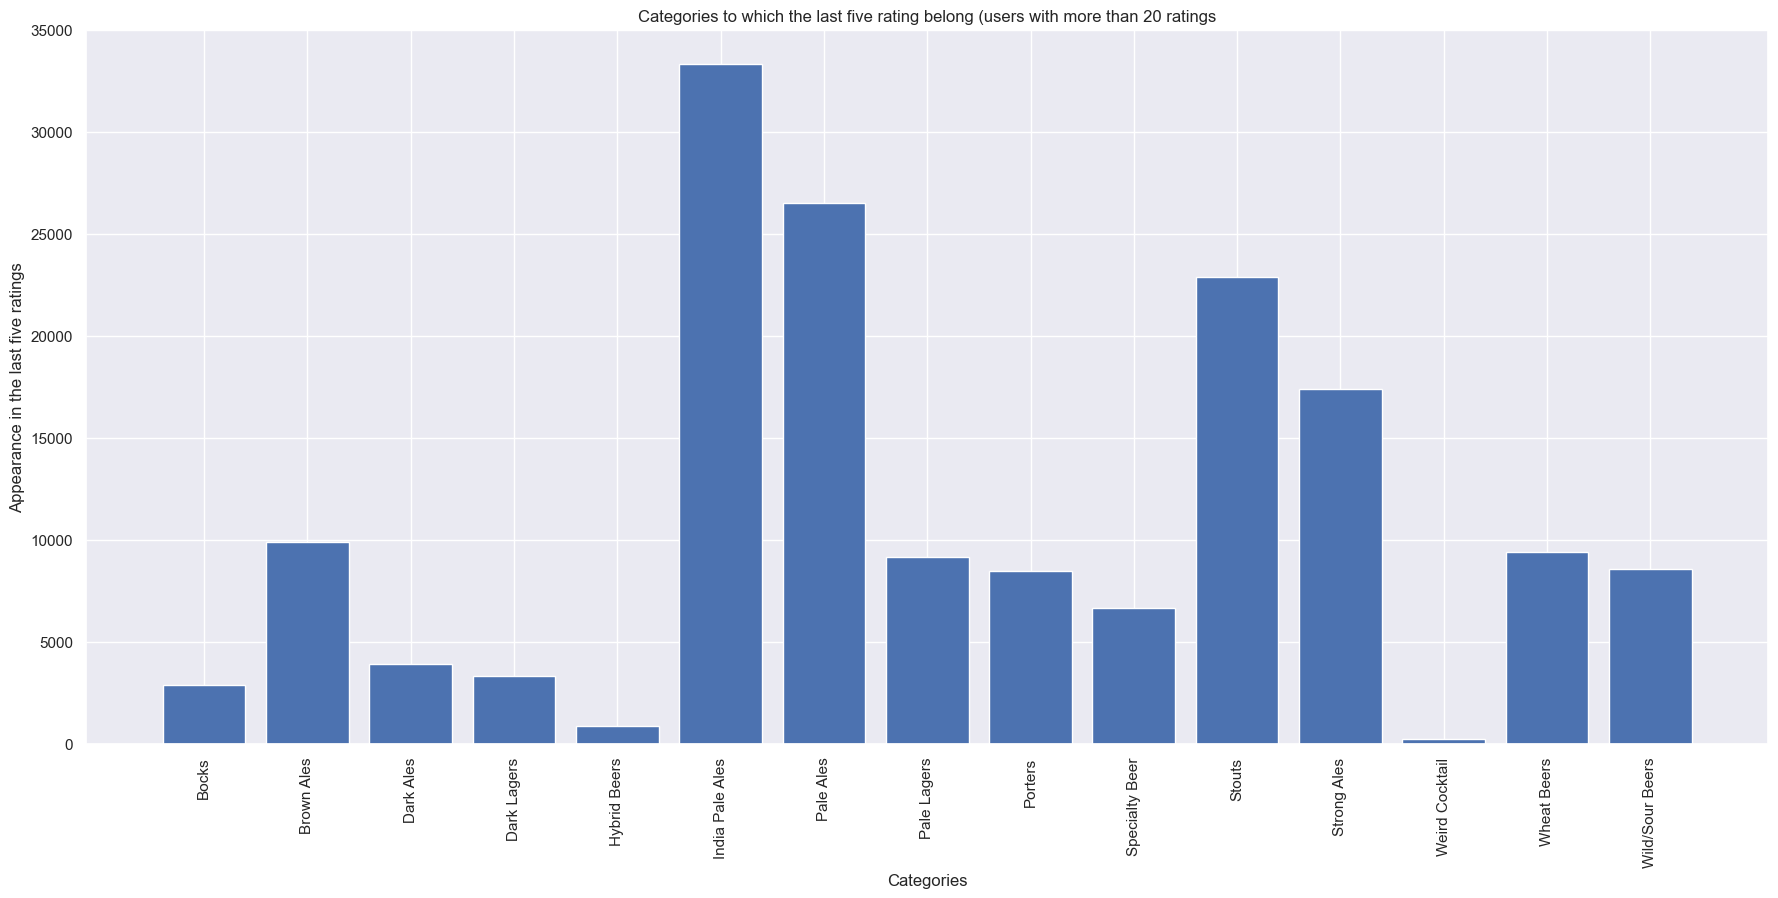

In [ ]:
#General distribution of the last five ratings!

vals = []
for cat, count in last_categories_dict.items():
    vals.append((cat,count))
vals = sorted(vals, key = lambda tup: tup[0])

cat_last = []
count_last = []

for val in vals:
    cat_last.append(val[0])
    count_last.append(val[1])

plt.bar(cat_last, count_last)
plt.xlabel('Categories')
plt.xticks(rotation = 90)
plt.ylabel('Appearance in the last five ratings')
plt.title("Categories to which the last five rating belong (users with more than 20 ratings")
pass

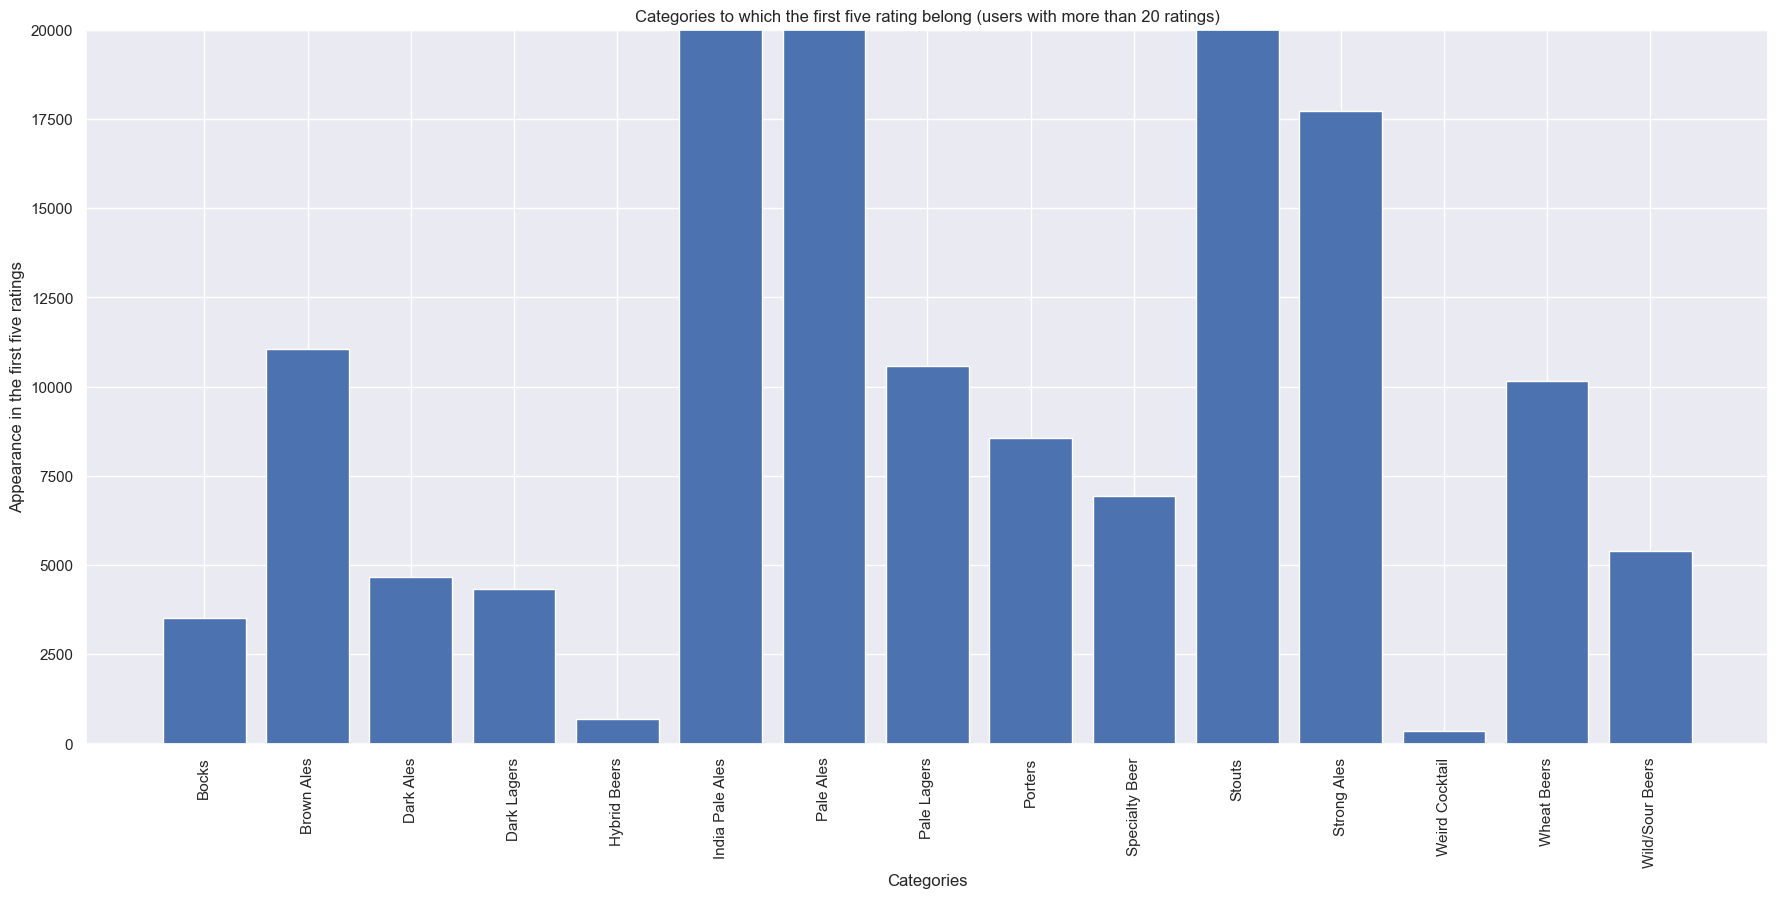

In [ ]:
#General distribution of the five first ratings!

vals = []
for cat, count in first_categories_dict.items():
    vals.append((cat,count))
vals = sorted(vals, key = lambda tup: tup[0])

cat_first = []
count_first = []

for val in vals:
    cat_first.append(val[0])
    count_first.append(val[1])

plt.bar(cat_first, count_first)
plt.xlabel('Categories')
plt.xticks(rotation = 90)
plt.ylim(0,20000)
plt.ylabel('Appearance in the first five ratings')
plt.title("Categories to which the first five rating belong (users with more than 20 ratings)")
pass


Below, the percentage of change between 5 first and 5 last beers. We see some clear change, but is it due to a global trend ? And how to know that ? 

In [ ]:
change_percentage = []
for count_f, count_l in zip(count_first,count_last):
    change_percentage.append((count_l-count_f)/count_f)
df_percentage = pd.DataFrame(change_percentage, cat_first)
df_percentage

,0
Bocks,-0.192635
Brown Ales,-0.106063
Dark Ales,-0.165634
Dark Lagers,-0.236380
Hybrid Beers,0.253687
India Pale Ales,0.043919
Pale Ales,0.007368
Pale Lagers,-0.135986
Porters,-0.008883
Specialty Beer,-0.040000
